# A COMPREHENSIVE ANALYSIS OF CHICAGO CRIME DATA (2001 - 2022)

### Importing of all necessary libraries.

In [1]:
import pandas as pd
import math
from datetime import datetime as dt
import seaborn as sns
import re
import matplotlib.pyplot as plt
import tabulate

### Loading of the Chicago Crime dataset into Jupyter Notebook for analysis.

In [2]:
filepath = "C:/Users/user/Desktop/eze/onecampus/"
crime = pd.read_csv(filepath+"crime_data_Proj1.csv",index_col=0)

Observe some features of the Chicago crime dataset.

In [3]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278726 entries, 0 to 2278725
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  int64  
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float64
 21  Location              object 
dtypes: bool(2), float64(7), int64(3), object(1

## DATA CONVERSION & CLEANING
Here data quality issues would be spotted for each column and change would be effected to appropriately clean and mitigate these issues.

In [4]:
crime_clean = crime

### 1. Date
The Date column seems to be in the form of a string. This should be converted to datetime to be analyzed as it is infact a timestamp.

In [5]:
time_format = '%m/%d/%Y %H:%M:%S %p'
crime_clean['Date'] = crime_clean['Date'].apply(lambda x: x if type(x)!=str else dt.strptime(x, time_format))

### 2. District, Ward, Community Area & Beat.
The 4 columns mentioned above are of numeric data types: int, float. However, as elements of location (i.e the location a certain crime occured), these should be regarded as object - string.

In [6]:
# Created a function that returns null if the value in a column is null & converts to a string if it is not
def to_str(_unit):
    if isinstance(_unit, str) or math.isnan(_unit):
        unit_done = _unit
    else:
        unit_done = str(int(_unit))
    return unit_done

# APPLIED the to_str function on relevant columns
BCDW = ['Beat', 'Community Area', 'District', 'Ward']
crime_clean[BCDW] = crime_clean[BCDW].applymap(to_str)

### Missing Values

In [7]:
crime_clean.isna().sum()

ID                           0
Case Number                  1
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      2877
Arrest                       0
Domestic                     0
Beat                         0
District                    12
Ward                    184695
Community Area          184267
FBI Code                     0
X Coordinate             23985
Y Coordinate             23985
Year                         0
Updated On                   0
Latitude                 23985
Longitude                23985
Location                 23985
dtype: int64

+ **Case Number** has 1 missing value and since these are semi-unique values, they would be dropped.

In [8]:
crime_clean = crime_clean.dropna(subset=['Case Number'])

# DATA MANIPULATION
Here we look for more features or columns to extract from our dataset for it hold more analytical water, as it were.

In [9]:
crime_tweak = crime_clean

### 1. Block

Observe the first few records of the Block column. This holds the full address of the location the crime was reported.

In [10]:
crime_tweak['Block'].head(40).values

array(['085XX S MUSKEGON AVE', '092XX S ELLIS AVE', '062XX N TRIPP AVE',
       '0000X N KEELER AVE', '016XX W HARRISON ST', '003XX W 28 PL',
       '006XX S CENTRAL AVE', '043XX W POTOMAC AVE', '032XX W PIERCE AVE',
       '021XX N CALIFORNIA AVE', '031XX W WARREN BLVD',
       '058XX S KEDZIE AVE', '014XX N ELK GROVE AVE',
       '076XX S HALSTED ST', '042XX S INDIANA AVE', '019XX W MADISON ST',
       '047XX W FULTON ST', '009XX W GRACE ST', '002XX N LOREL AVE',
       '023XX S STATE ST', '022XX N NATCHEZ AVE', '133XX S BRANDON AVE',
       '036XX S LAKE PARK AVE', '003XX S MICHIGAN AVE', '001XX W 72ND ST',
       '078XX S PHILLIPS AVE', '025XX W BERWYN AVE', '077XX S PEORIA ST',
       '008XX N MICHIGAN AVE', '0000X W DIVISION ST',
       '065XX S JUSTINE ST', '065XX S ELLIS AVE',
       '053XX W BLOOMINGDALE AVE', '011XX S WESTERN AVE',
       '005XX W DIVISION ST', '059XX S KEDVALE AVE', '031XX S HALSTED ST',
       '001XX S PULASKI RD', '001XX N DAMEN AVE', '048XX N AVERS AVE'],

#### USPS suffix abbreviations
This is a universal standard for street abbreviations and their full forms.

This table can be found in the link - https://www.pb.com/docs/us/pdf/sis/mail-services/usps-suffix-abbreviations.pdf


In [11]:
ABBREV = pd.read_excel(filepath + 'USPS SUFFIX ABBREVIATIONS.xlsx')
print(ABBREV.head(20).to_markdown())

|    | Primary Street   | Commonly Used Street   | Postal Service Standard   |
|---:|:-----------------|:-----------------------|:--------------------------|
|  0 | ALLEY            | ALLEE                  | ALY                       |
|  1 | ALLEY            | ALLEY                  | ALY                       |
|  2 | ALLEY            | ALLY                   | ALY                       |
|  3 | ALLEY            | ALY                    | ALY                       |
|  4 | ANNEX            | ANEX                   | ANX                       |
|  5 | ANNEX            | ANNEX                  | ANX                       |
|  6 | ANNEX            | ANNX                   | ANX                       |
|  7 | ANNEX            | ANX                    | ANX                       |
|  8 | ARCADE           | ARC                    | ARC                       |
|  9 | ARCADE           | ARCADE                 | ARC                       |
| 10 | AVENUE           | AV                     | A

In [12]:
# We would convert all values in this dataframe to lower case
abbrev = ABBREV.apply(lambda x: x.astype(str).str.lower())
# also we would convert the dataframe to a dictionary for value matching
abbrev_dict = dict(zip(abbrev['Commonly Used Street'], abbrev['Primary Street']))

In [13]:
# CREATED a function to extract street type out of the 'Block' column
def func_block(itB):
    eachB = str(itB)
    # ran a regex search on the Block column and output the type of Block.
    searched_txt = re.search("\w*$", itB).group().lower()
    # ran an if-statement that outputs the corresponding full name if there's a match
    if searched_txt in abbrev_dict.keys():
        block_done = abbrev_dict[searched_txt]
    else:
        block_done = searched_txt
    # another if-statement that collates all unmatched regex expressions as 'Not Found'
    return block_done if block_done in abbrev_dict.values() else 'Not Found'

# APPLIED function on the relevant column
# crime_tweak["blockType"] = crime_tweak["Block"].apply(func_block)
crime_tweak = crime_tweak.assign(blockType = crime_tweak['Block'].apply(func_block))

In [14]:
# CREATED a function to extract street name from the full address a crime was reported
def street_func(it2B):
    # PERFORMED regex search and replace apropriately
    regex1st = re.search("\s[N|S|W|E]\s.*$", it2B).group()
    regexOut = re.sub("^\s[N|S|W|E]\s", '', regex1st)
    return regexOut

# APPLIED function on relevant column
crime_tweak = crime_tweak.assign(actualStreet = crime_tweak['Block'].apply(street_func))

### 2. Date

In [15]:
# CREATED a function to extract all the features mentioned above
def datefunc(itD):
    dow = itD.strftime("%A")
    mnth = itD.strftime("%m")
    _hour = itD.strftime("%H")
    int_hour = int(_hour)
    if int_hour < 6:
        tod = 'Night'
    elif int_hour < 12:
        tod = 'Morning'
    elif int_hour < 17:
        tod = 'Afternoon'
    elif int_hour < 20:
        tod = 'Evening'
    elif int_hour >= 20:
        tod = 'Night'
    return dow, _hour, tod, mnth

# APPLIED datefunc() on the relevant column to get a series of outputs
datefunc_applied = crime_tweak['Date'].apply(datefunc)
date_df = pd.DataFrame(datefunc_applied.tolist())

# CREATED new columns and fill with values gotten from the above operation.
crime_tweak[['dayOfWeek','hourDay','timeOfDay','month']] = date_df

#### Conclusion!
After all stages of data conversion and manipulation have been finished, we move to the next stage of our analysis.

In [16]:
crime_df = crime_tweak
print(crime_df.head().T.to_markdown())

|                      | 0                             | 1                             | 2                             | 3                             | 4                                      |
|:---------------------|:------------------------------|:------------------------------|:------------------------------|:------------------------------|:---------------------------------------|
| ID                   | 6407111                       | 11398199                      | 5488785                       | 11389116                      | 12420431                               |
| Case Number          | HP485721                      | JB372830                      | HN308568                      | JB361368                      | JE297624                               |
| Date                 | 2008-07-26 02:30:00           | 2018-07-31 10:57:00           | 2007-04-27 10:30:00           | 2018-07-23 08:55:00           | 2021-07-11 06:40:00                    |
| Block                | 085XX

## DATA ANALYSIS

Let's dive into the data and gain trustworthy insights from charts & graphs!

### 1. How many unique crime reports are in this dataset?

In [17]:
year_range = crime_df['Year'].max() - crime_df['Year'].min()
total_crime = crime_df['ID'].nunique()
per_year = total_crime//year_range

print("There have been {0} unique crime reports.\nIn {1} years.\nThis is an estimate of {2} crime reports every year.".format(total_crime, year_range, per_year))

There have been 2278725 unique crime reports.
In 21 years.
This is an estimate of 108510 crime reports every year.


### 2. What are the most crime-prone locations?

In [18]:
blockG = pd.DataFrame(crime_df.groupby('Block').size(), columns = ['frequency'])
blockG = blockG.sort_values('frequency', ascending = False).reset_index()
#
print(blockG.head(16).to_markdown())

|    | Block                               |   frequency |
|---:|:------------------------------------|------------:|
|  0 | 100XX W OHARE ST                    |        4878 |
|  1 | 001XX N STATE ST                    |        4362 |
|  2 | 076XX S CICERO AVE                  |        3010 |
|  3 | 008XX N MICHIGAN AVE                |        2800 |
|  4 | 0000X N STATE ST                    |        2587 |
|  5 | 0000X W TERMINAL ST                 |        1819 |
|  6 | 064XX S DR MARTIN LUTHER KING JR DR |        1692 |
|  7 | 063XX S DR MARTIN LUTHER KING JR DR |        1649 |
|  8 | 023XX S STATE ST                    |        1542 |
|  9 | 001XX W 87TH ST                     |        1346 |
| 10 | 008XX N STATE ST                    |        1320 |
| 11 | 012XX S WABASH AVE                  |        1301 |
| 12 | 0000X S STATE ST                    |        1282 |
| 13 | 022XX S STATE ST                    |        1281 |
| 14 | 006XX N MICHIGAN AVE                |        1276

### 3. What streets have had the most crime reports?

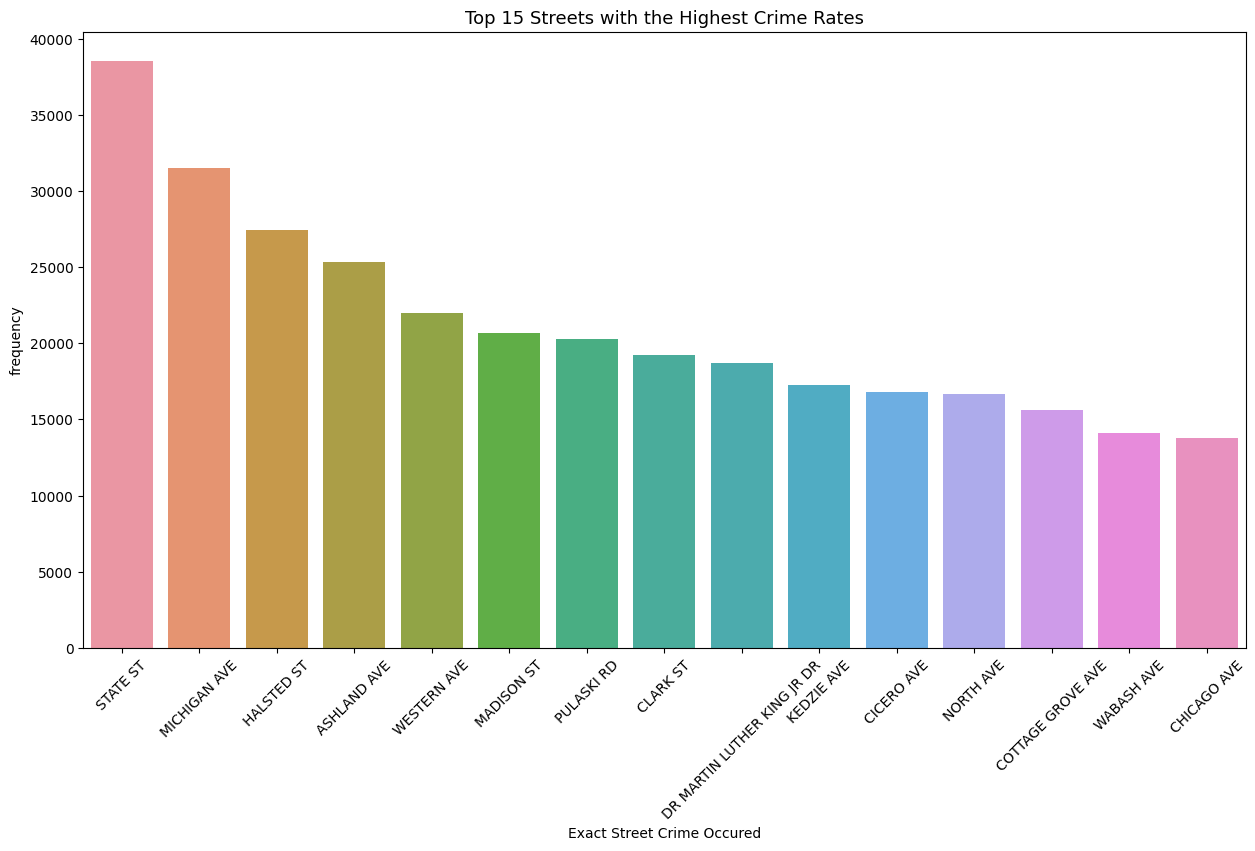

In [19]:
# CREATED a table to hold the street values and frequency of occurence
st_freq = pd.DataFrame(crime_df.groupby('actualStreet').size(), columns=['frequency'])
st_freq = st_freq.reset_index()

# FILTER off streets that appear only once in this table
st_freq = st_freq[st_freq['actualStreet']!=1].sort_values('frequency', ascending=False)

# now to plot
plt.figure(figsize=(15, 8))
plt.title('Top 15 Streets with the Highest Crime Rates', fontsize=13)
sns.barplot(data= st_freq[:15], x='actualStreet', y='frequency')
plt.xticks(rotation = 45)
plt.xlabel('Exact Street Crime Occured')
plt.show()

### 4. Where does crime happen the most in Chicago?

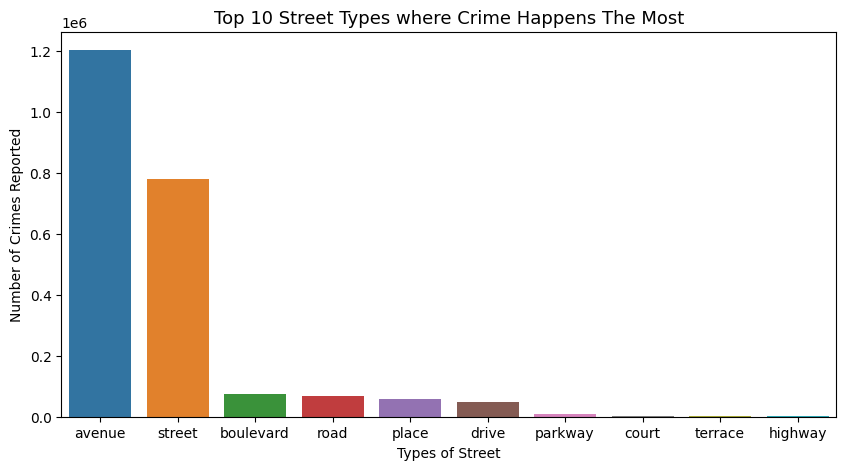

In [20]:
# We do a groupby on 'blockType' to to get a table of types and frequency
blockTypeG = crime_df.groupby('blockType').size()
blockTypeG = pd.DataFrame(blockTypeG.sort_values(ascending=False),columns=['frequency'])
# We reset the index of this dataframe
blockTypeG = blockTypeG.reset_index()
# FILTER off 'Not Found' values
subBlock = blockTypeG[blockTypeG['blockType'] != 'Not Found']

# now to plot
plt.figure(figsize=(10, 5))
plt.title('Top 10 Street Types where Crime Happens The Most', fontsize=13)

sns.barplot(data=subBlock[:10], x='blockType', y='frequency')
plt.xlabel('Types of Street')
plt.ylabel('Number of Crimes Reported')
plt.show()

### 5. What time in the day does crime happen the most?

#### 5.1 Initial Time Analysis

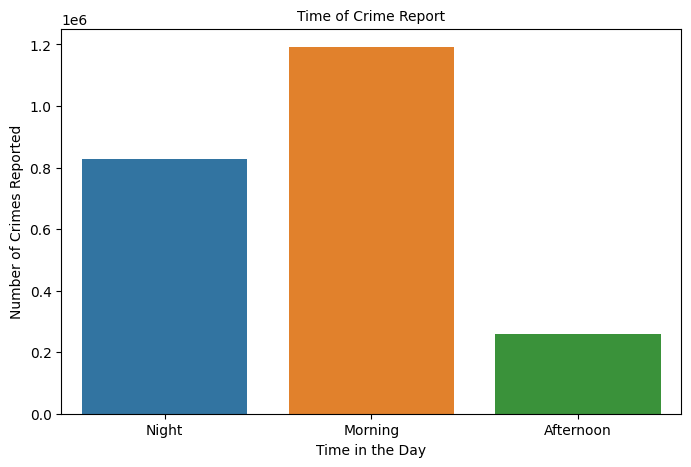

In [21]:
plt.figure(figsize=(8,5))
plt.title('Time of Crime Report', fontsize=10)

sns.countplot(data=crime_df, x='timeOfDay')
plt.xlabel('Time in the Day')
plt.ylabel('Number of Crimes Reported')
plt.show()


#### 5.2 Comprehensive Time Analysis

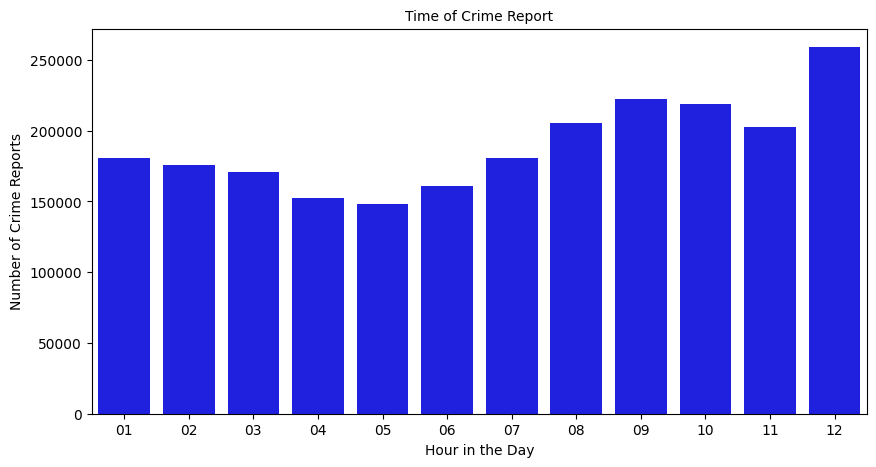

In [22]:
crime_df = crime_df.sort_values('hourDay')
# now to plot
plt.figure(figsize=(10,5))
plt.title('Time of Crime Report', fontsize = 10)
#
sns.countplot(data = crime_df , x = 'hourDay', color='blue')
plt.xlabel('Hour in the Day')
plt.ylabel('Number of Crime Reports')
plt.show()

### 6. In what months have the highest number of crimes been reported?

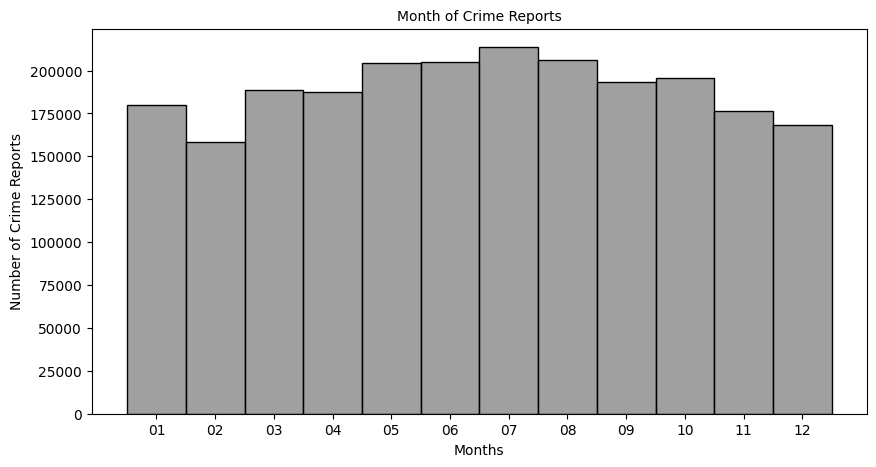

In [23]:
plt.figure(figsize=(10,5))
plt.title('Month of Crime Reports', fontsize=10)

sns.histplot(data = crime_df.sort_values('month'), x = 'month', color= 'grey')
plt.ylabel('Number of Crime Reports')
plt.xlabel('Months')
plt.show()

### 7. What days of the week is crime reported the most in?

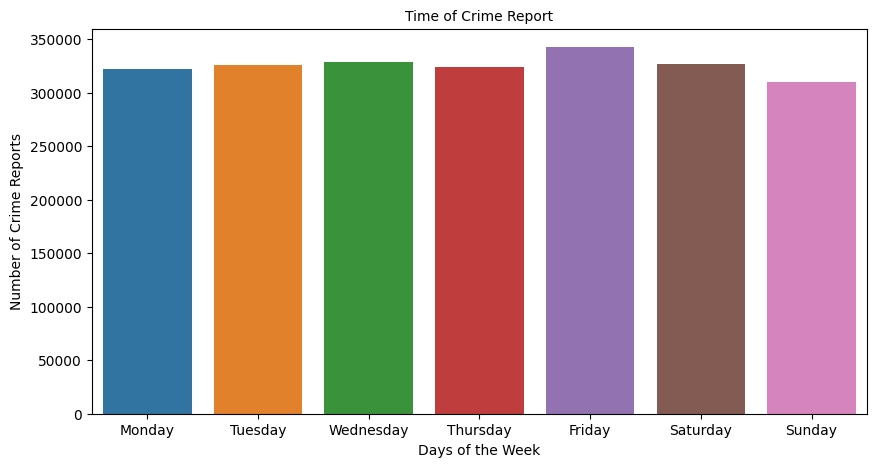

In [24]:
ordered_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#order dataframe so that days of the week comes out ordered
crime_df['dayOfWeek'] = crime_df['dayOfWeek'].astype('category').cat.reorder_categories(ordered_days)

#now to plot
plt.figure(figsize=(10,5))
plt.title('Time of Crime Report', fontsize = 10)
#
sns.countplot(data = crime_df , x = 'dayOfWeek')
plt.xlabel('Days of the Week')
plt.ylabel('Number of Crime Reports')
plt.show()

### 7. What types of crime happen most frequently in Chicago?

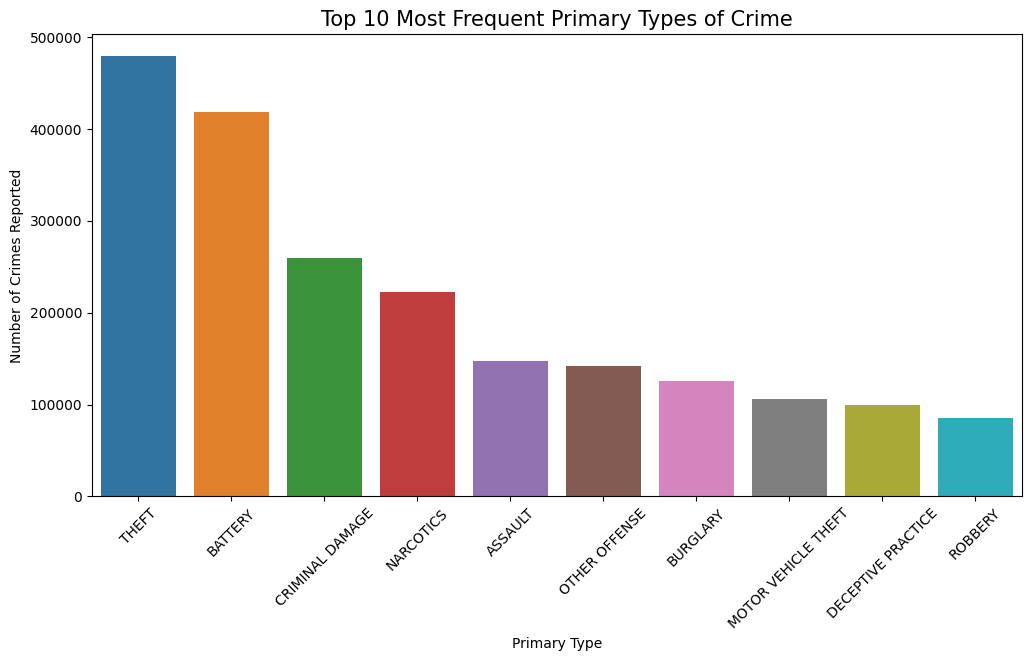

In [25]:
# 1. We do a groupby on 'Primary Type' to get a table category and frequency
pt_freq = pd.DataFrame(crime_df.groupby('Primary Type').size(),columns=['frequency'])
# We reset the index of this dataframe
pt_freq = pt_freq.reset_index()
pt_freq = pt_freq.sort_values('frequency', ascending=False)
# now to plot

plt.figure(figsize=(12,6))
plt.title('Top 10 Most Frequent Primary Types of Crime', fontsize=15)

#sns.barplot(data = pt_freq[pt_freq['frequency']>100000], x = 'Primary Type', y='frequency')

sns.barplot(data=pt_freq[:10], x='Primary Type', y='frequency')
plt.ylabel('Number of Crimes Reported')
plt.xticks(rotation = 45)
plt.show()

### Analysis on Elements of Location against Rate of Arrest

In [26]:
#CREATED a function to accept columns of crime_df - elements of location - and pivots it against Arrest column, as well as a parameter for Bottom N
def locate_func(eachL, bottomN):
    bottomN = int(bottomN)
    # extracted a table of relevant eachL & Arrest values
    df = pd.DataFrame(crime_df.groupby([eachL, 'Arrest']).size())
    df = df.reset_index()
    # pivoted columns based on Arrest into two columns: True or False
    pivot_df  = df.pivot(index = eachL, columns = 'Arrest', values = 0)
    pivot_df = pivot_df.reset_index().rename_axis(None, axis=1)
    # calculated RateofArrest column in percent
    pivot_df['RateOfArrest'] = 100 * pivot_df[True] / (pivot_df[True] + pivot_df[False])
    pivot_df = pivot_df.sort_values('RateOfArrest')
    # plot charts appropriately with relevant parameters
    plt.figure(figsize=(10,4))
    title = "The {0}s with the {1} Lowest Rates of Arrest".format(eachL, bottomN)
    plt.title(label = title, fontsize=12)
    # now to plot
    return sns.barplot(data = pivot_df[:bottomN], x = eachL, y = 'RateOfArrest'), plt.ylabel('Percentage of Rate of Arrest')
    


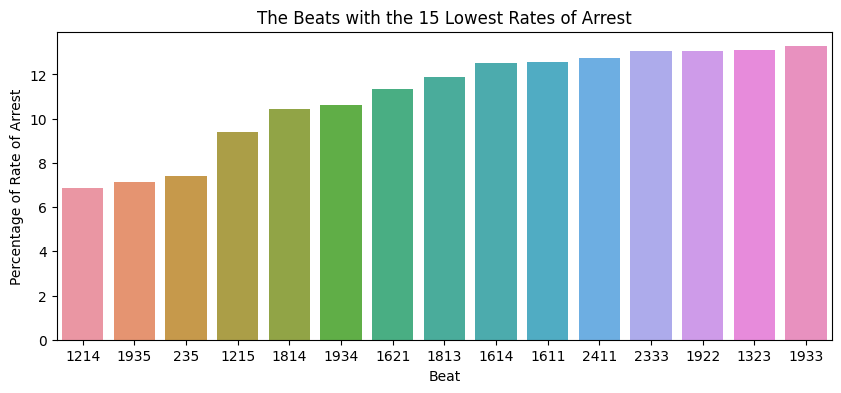

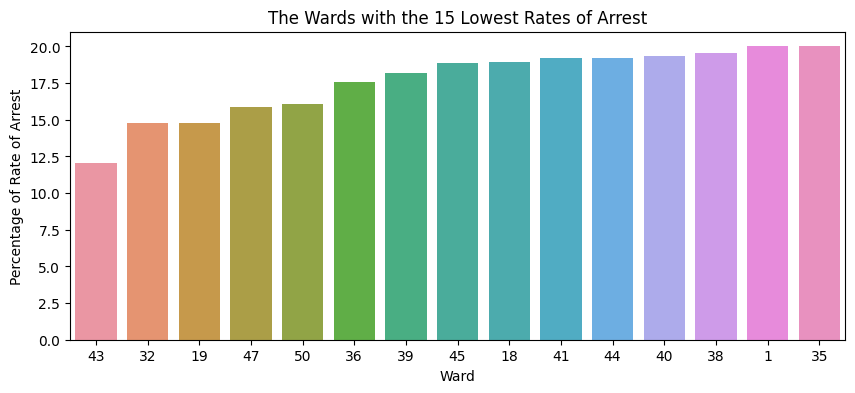

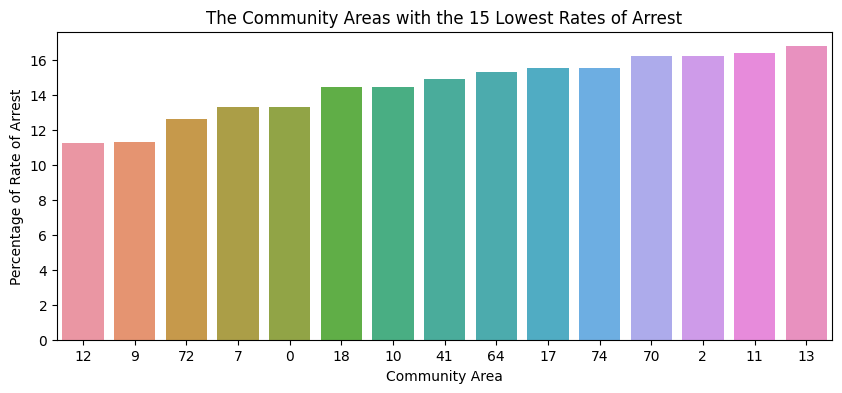

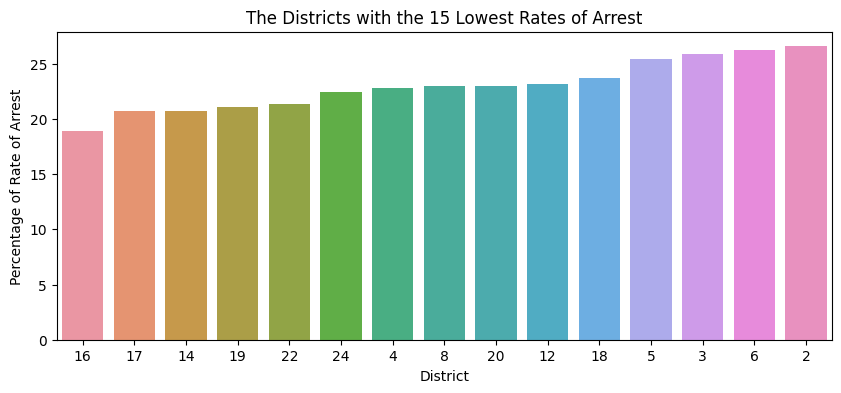

In [27]:
# now we plot all 4 graphs
locate_func('Beat', 15)
locate_func('Ward', 15)
locate_func('Community Area', 15)
locate_func('District', 15)

plt.ylabel('Percentage of Rate of Arrest')
plt.show()